# Naive Bayes and Decision Trees

In [79]:
%matplotlib inline

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from IPython.IPython.display import mark

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

## Load Data

In [3]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0CSPPHXXV,Apple Watch Ultra 2 (GPS + Cellular 49mm) Rugg...,https://m.media-amazon.com/images/I/814xH1gpid...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Rugged-T...,699.97,2024-02-01,779.99,NaN,NaN
1,B0BDJ4MGFQ,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91WpS8h5Jv...,False,4.7,4100.0,https://www.amazon.com/Apple-Cellular-Starligh...,689.00,2024-02-01,799.00,NaN,NaN
2,B0CSV7LK7D,AppleWatch Series 9 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61DZ+Vezk0...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,679.00,2024-02-01,679.00,NaN,NaN
3,B0B8GHHD2F,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/51aQmgx9Ql...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
4,B0B8GDV9GN,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61O671oWHg...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1389694,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1389695,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1389696,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1389697,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


In [121]:
# df_az.sample(frac=0.05).to_csv("../data/output/products_sample.csv", index=False)

## Naive Bayes

### Data Prep

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [107]:
# Remove rows with no category
df_nb = df_az.dropna(subset=["Category"])[["Name", "Category"]]
# Stratified Sampling: use groupby and apply to select sample which maintains the population group ratios
# Sample 33% of each category
df_nb = df_nb.groupby("Category").apply(lambda x: x.sample(frac=0.333, random_state=42)).droplevel(0)

# Split into training and testing data, stratifying on the label for fairness in evaluation
# Split before vectorization for fairness
nb_text_train, nb_text_test, nb_label_train, nb_label_test = train_test_split(df_nb["Name"], df_nb["Category"], random_state=42, stratify=df_nb["Category"])

stop_words = ["and", "for", "with", "to"]

# Transform text into vectors
countVect = CountVectorizer(stop_words=stop_words)
tfVect = TfidfTransformer(use_idf=False)
nb_counts_train = countVect.fit_transform(nb_text_train)
# Vector matrix has already been made by fitting to test data, need to use same matrix
nb_counts_test = countVect.transform(nb_text_test)
nb_tf_train = tfVect.fit_transform(nb_counts_train)
nb_tf_test = tfVect.transform(nb_counts_test)

print(nb_counts_train.max(), nb_counts_test.max(), nb_tf_train.max(), nb_tf_test.max())

# Transform text into occurence binary for Bernoulli NB
binVect = CountVectorizer(binary=True, stop_words=stop_words)
nb_bin_train = binVect.fit_transform(nb_text_train)
# Vector matrix has already been made by fitting to test data, need to use same matrix
nb_bin_test = binVect.transform(nb_text_test)

print(nb_bin_train.max(), nb_bin_train.shape, nb_bin_test.max(), nb_bin_test.shape)

18 23 1.0 1.0
1 (343558, 183699) 1 (114520, 183699)


In [125]:
nb_tf_train

<343558x183699 sparse matrix of type '<class 'numpy.float64'>'
	with 5305684 stored elements in Compressed Sparse Row format>

### Model Training

In [108]:
# Input is the counts
mult_c_nb = MultinomialNB()
comp_c_nb = ComplementNB()
# Input is the text frequency (tf)
mult_tf_nb = MultinomialNB()
comp_tf_nb = ComplementNB()
# Input is the binary occurence vector
bern_nb = BernoulliNB()

models = [mult_c_nb, comp_c_nb, mult_tf_nb, comp_tf_nb, bern_nb]
data_type = ["Counts", "Counts", "TF", "TF", "Occurence"]
train_data = {"Counts": nb_counts_train, "TF": nb_tf_train, "Occurence": nb_bin_train}
test_data = {"Counts": nb_counts_test, "TF": nb_tf_test, "Occurence": nb_bin_test}

for i, model in enumerate(models):
    model.fit(train_data[data_type[i]], nb_label_train)

### Results and Viz

In [126]:
data_acc = []
for i, model in enumerate(models):
    pred_labels = model.predict(test_data[data_type[i]])
    print(model.__class__, data_type[i], np.mean(pred_labels == nb_label_test))
    acc = accuracy_score(nb_label_test, pred_labels)
    if type(model) in [MultinomialNB , BernoulliNB]:
        data_acc.append({"Model": model.__class__, "Data Format": data_type[i], "Accuracy": acc})

<class 'sklearn.naive_bayes.MultinomialNB'> Counts 0.6825969263010828
<class 'sklearn.naive_bayes.ComplementNB'> Counts 0.6518512050296892
<class 'sklearn.naive_bayes.MultinomialNB'> TF 0.6065490743974852
<class 'sklearn.naive_bayes.ComplementNB'> TF 0.6528815927348934
<class 'sklearn.naive_bayes.BernoulliNB'> Occurence 0.22927872860635698


,Model,Data Format,Accuracy
0,<class 'sklearn.naive_bayes.MultinomialNB'>,Counts,0.682597
1,<class 'sklearn.naive_bayes.MultinomialNB'>,TF,0.606549
2,<class 'sklearn.naive_bayes.BernoulliNB'>,Occurence,0.229279


In [132]:
pd.DataFrame(data_acc).sort_values("Accuracy", ascending=False).to_markdown(index=False)

"| Model                                       | Data Format   |   Accuracy |\n|:--------------------------------------------|:--------------|-----------:|\n| <class 'sklearn.naive_bayes.MultinomialNB'> | Counts        |   0.682597 |\n| <class 'sklearn.naive_bayes.MultinomialNB'> | TF            |   0.606549 |\n| <class 'sklearn.naive_bayes.BernoulliNB'>   | Occurence     |   0.229279 |"

In [133]:
best_pred = models[0].predict(nb_counts_test)
acc_bycat = classification_report(nb_label_test, best_pred, output_dict=True)

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [151]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest empirical log probabilities, per class"""
    feature_names = vectorizer.get_feature_names_out()
    classes = list(clf.classes_)
    top = []
    for class_label in class_labels:
        i = classes.index(class_label)
        top10 = np.argsort(clf.feature_log_prob_[i])[-n:]
        top.append([feature_names[j] for j in top10])
        # print("%s: %s" % (class_label,
        #       " ".join(feature_names[j] for j in top10)))
    return top
        
        

In [152]:
top15 = pd.DataFrame(acc_bycat).T.reset_index(names="Category").sort_values("f1-score", ascending=False).iloc[:15, :-1]

top15["Top Feature Words"] = print_top10(countVect, models[0], top15["Category"], 6)

print(top15.to_markdown(index=False))

| Category                        |   precision |   recall |   f1-score | Top Feature Words                                                    |
|:--------------------------------|------------:|---------:|-----------:|:---------------------------------------------------------------------|
| Computers & Tablets             |    0.898876 | 0.981595 |   0.938416 | ['laptop', '10', 'ssd', 'intel', 'core', 'ram']                      |
| Knitting & Crochet Supplies     |    0.933824 | 0.937962 |   0.935888 | ['set', 'kit', 'needles', 'knitting', 'crochet', 'yarn']             |
| Additive Manufacturing Products |    0.937198 | 0.9312   |   0.934189 | ['pla', 'pro', 'filament', 'ender', 'printer', '3d']                 |
| Sexual Wellness Products        |    0.981538 | 0.859838 |   0.916667 | ['vibrator', 'women', 'dildo', 'adult', 'toys', 'sex']               |
| Needlework Supplies             |    0.926941 | 0.900888 |   0.913728 | ['needle', 'kits', 'cross', 'stitch', 'kit', 'embroidery

In [83]:
ConfusionMatrixDisplay(confusion_matrix(nb_label_test, best_pred)).plot()
plt.show()

Error in callback <function flush_figures at 0x10b0eed40> (for post_execute):


KeyboardInterrupt: 

In [85]:
models[0].classes_

array(['Abrasive & Finishing Products', 'Accessories & Supplies',
       'Additive Manufacturing Products', 'Arts & Crafts Supplies',
       'Arts, Crafts & Sewing Storage',
       'Automotive Enthusiast Merchandise',
       'Automotive Exterior Accessories',
       'Automotive Interior Accessories',
       'Automotive Paint & Paint Supplies',
       'Automotive Performance Parts & Accessories',
       'Automotive Replacement Parts', 'Automotive Tires & Wheels',
       'Automotive Tools & Equipment', 'Baby',
       'Baby & Child Care Products', 'Baby & Toddler Feeding Supplies',
       'Baby & Toddler Toys', 'Baby Activity & Entertainment Products',
       "Baby Boys' Clothing & Shoes", 'Baby Care Products',
       'Baby Diapering Products', 'Baby Gifts',
       "Baby Girls' Clothing & Shoes", 'Baby Safety Products',
       'Baby Stationery', 'Baby Strollers & Accessories',
       'Baby Travel Gear', 'Backpacks', 'Bath Products',
       'Beading & Jewelry Making', 'Beauty & Personal Ca

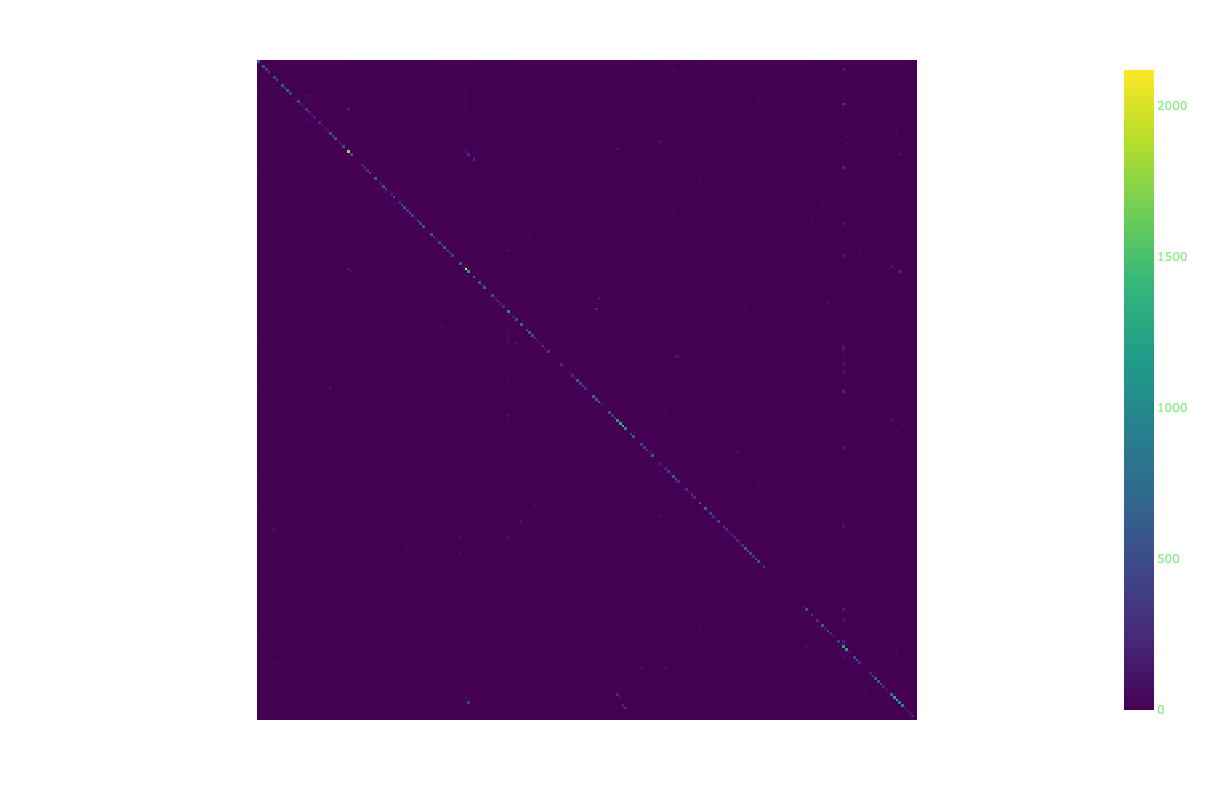

In [153]:
fig = px.imshow(confusion_matrix(nb_label_test, best_pred, labels=models[0].classes_), x=models[0].classes_, y=models[0].classes_)
fig.update_layout(xaxis_showticklabels=False, yaxis_showticklabels=False, height=800)
fig.show()

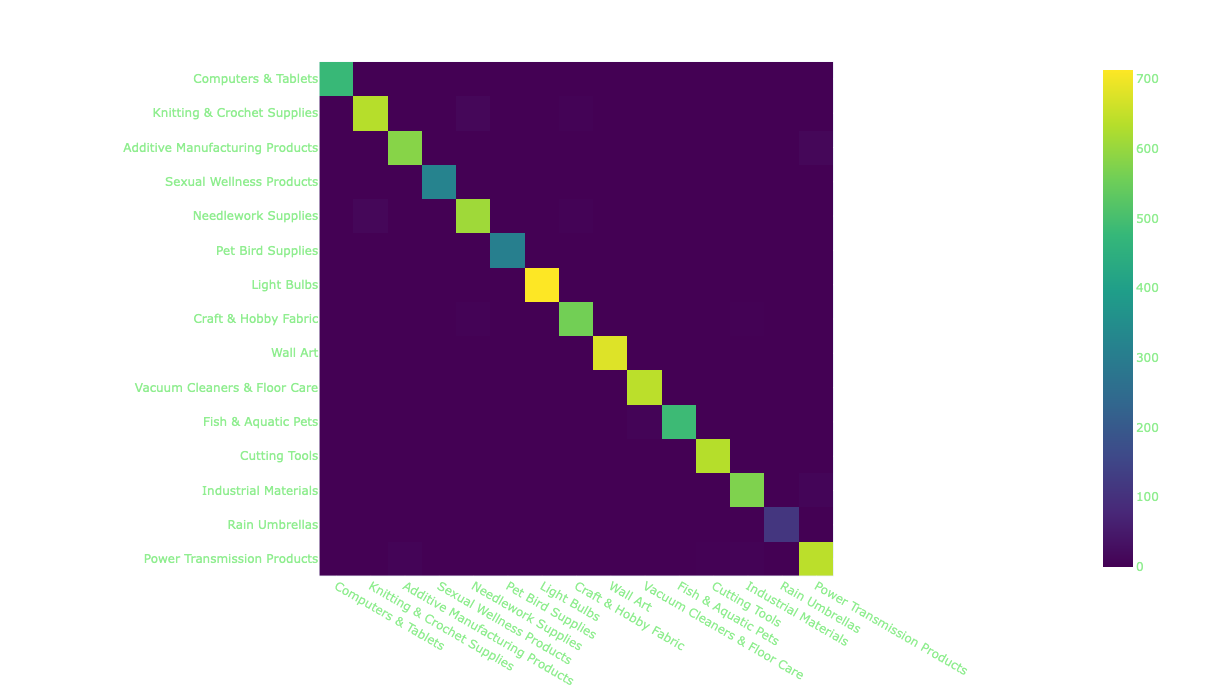

In [163]:
cm = confusion_matrix(nb_label_test, best_pred, labels=models[0].classes_)
top_inds = [list(models[0].classes_).index(i) for i in top15["Category"]]

cm[np.array(top_inds)[:, np.newaxis], top_inds]

fig = px.imshow(cm[np.array(top_inds)[:, np.newaxis], top_inds], x=top15["Category"], y=top15["Category"])
# fig.update_layout(xaxis_showticklabels=False, yaxis_showticklabels=False, height=800)
fig.update_layout(height=700)
fig.show()

In [98]:
list(countVect.get_feature_names_out()).index("baby")

52595

In [103]:
list(models[0].classes_).index("Automotive Interior Accessories")

7

In [164]:
len(models[0].classes_)

248

In [124]:
df_az.select_dtypes(include='number').columns

Index(['Stars', 'Reviews', 'Price', 'List Price', 'Bought In Month'], dtype='object')